In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import shap
import os
from datetime import datetime

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import( 
    classification_report,
    roc_auc_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve)
 

In [2]:
data=pd.read_excel("Data/Telco_customer_churn.xlsx")
print("\nInformation About Data:")
print(f"Shape:{data.shape}")
print(f"\n{data.info()} ")
print(f"Columns:{data.columns.tolist()}")
display(data.head())


Information About Data:
Shape:(7043, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-nu

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value', 'CLTV']
Churn Counts:
Churn Value
0    5174
1    1869
Name: count, dtype: int64

Overall Churn Rate:Churn Value
0    73.463013
1    26.536987
Name: proportion, dtype: float64

Duplicated Value:0


,Missing_Count,Missing_pct
Gender,0,0.0
Senior Citizen,0,0.0
Partner,0,0.0
Dependents,0,0.0
Tenure Months,0,0.0
Phone Service,0,0.0
Multiple Lines,0,0.0
Internet Service,0,0.0
Online Security,0,0.0
Online Backup,0,0.0


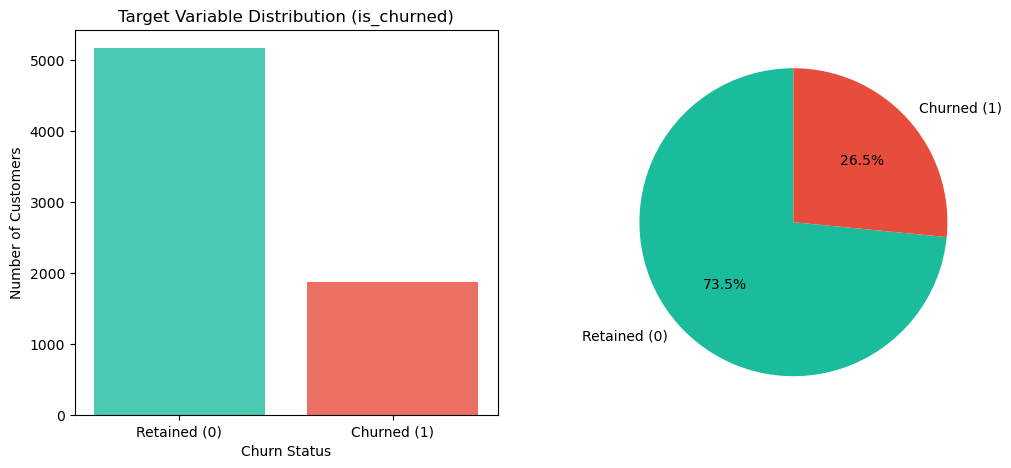

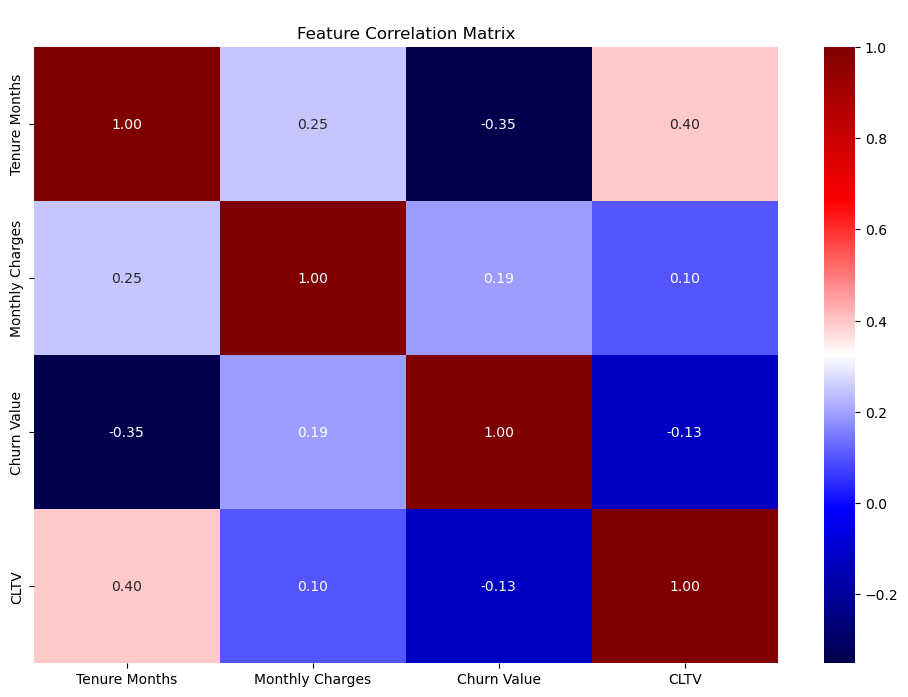

In [3]:
data[['Churn Label', 'Churn Value']].head(25)
data[['Internet Service', 'Online Security', 'Online Backup']].head()

df=data.copy()

df.drop(columns=['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude','Churn Label','Churn Score','Churn Reason'],inplace=True)
''' Churn Score is a derive from another model so it contain the predictives info about target variable,so include it cause dataleakage.
  Same as Churn reason is only available after the customer already churned since our motive is to predict churn before it happens so we drop it
'''

print(df.columns.tolist())
churn_count = df['Churn Value'].value_counts()
churn_pct = df['Churn Value'].value_counts(normalize=True) * 100
print(f"Churn Counts:\n{churn_count}")
print(f"\nOverall Churn Rate:{churn_pct}")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(['Retained (0)', 'Churned (1)'],churn_count.values,color=['#1abc9c', '#e74c3c'], alpha=0.8)
axes[0].set_title('Target Variable Distribution (is_churned)')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Number of Customers')
axes[1].pie(churn_count.values,labels=['Retained (0)', 'Churned (1)'],colors=['#1abc9c', '#e74c3c'],autopct='%1.1f%%',startangle=90 )

print(f"\nDuplicated Value:{df.duplicated().sum()}")

missing_df=pd.DataFrame({
    'Missing_Count':df.isnull().sum(),
    'Missing_pct':((df.isnull().sum()) / len(df))*100
})
display(missing_df)

plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True,cmap="seismic",fmt=".2f")
plt.title('\nFeature Correlation Matrix')
plt.show()

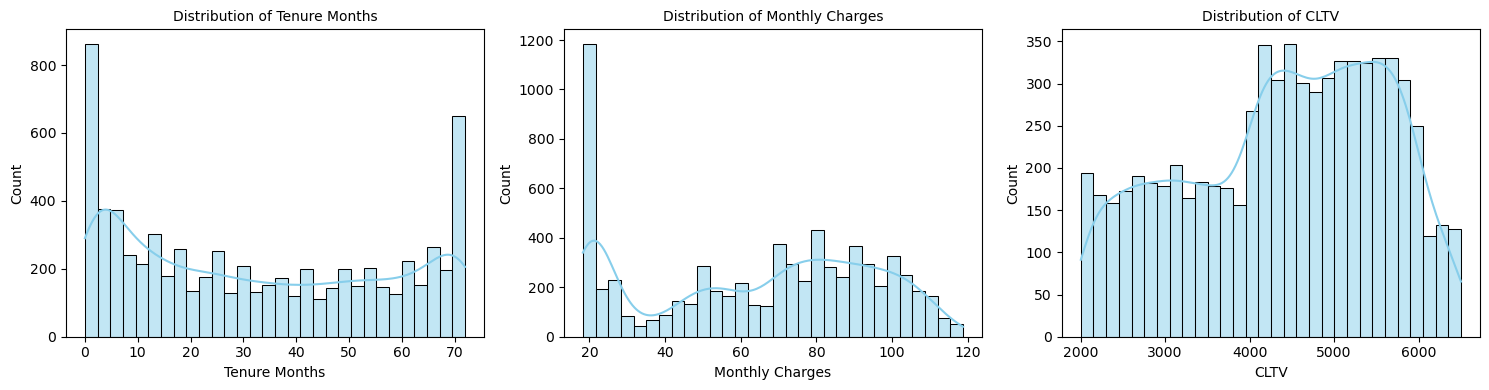

In [4]:
numerical_column=df.select_dtypes(include='number').columns.drop('Churn Value')
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes = axes.flatten()
for i, col in enumerate(numerical_column):
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
plt.tight_layout()
plt.show()

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Total Charges'],
      dtype='object')

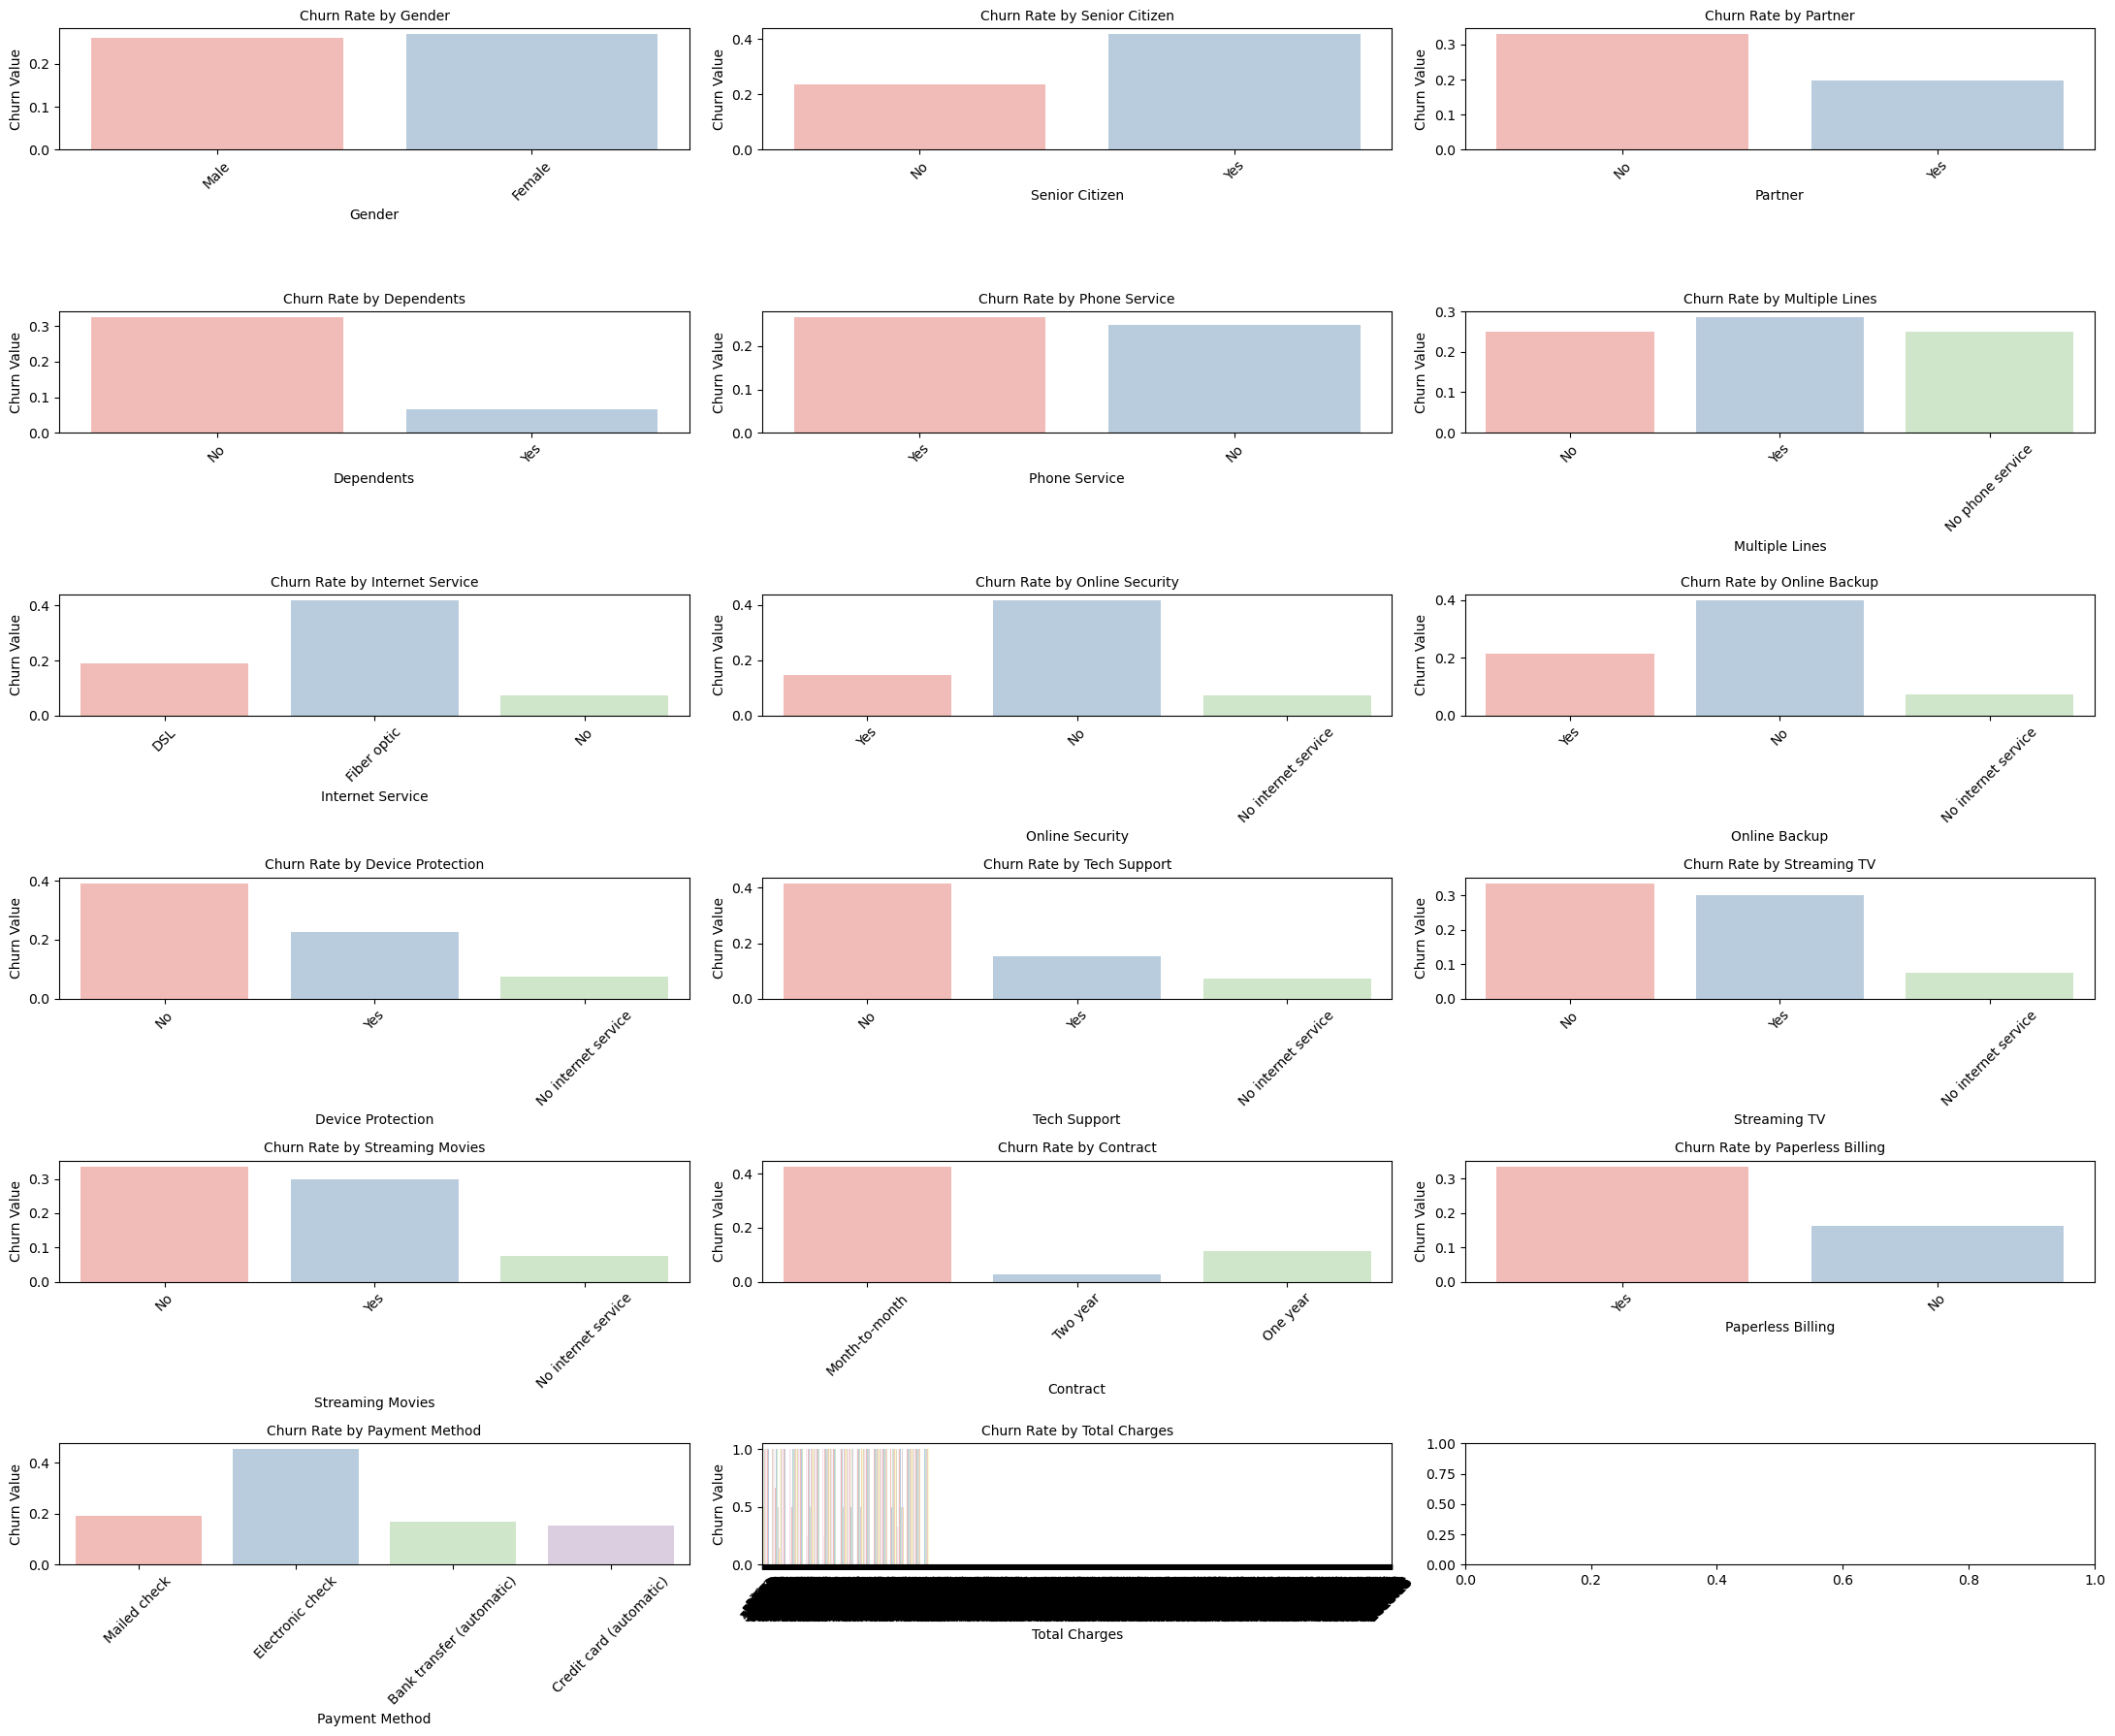

In [5]:
categorical_column=df.select_dtypes(include=['object','category']).columns
display(categorical_column)
fig, axes = plt.subplots(6, 3, figsize=(22, 18))
axes = axes.flatten()
for i, col in enumerate(categorical_column):
    sns.barplot(
        x=col,
        y=df['Churn Value'],
        data=df,
        errorbar=None,
        ax=axes[i],
        palette='Pastel1',
        hue=col,          
        legend=False      
    )
    axes[i].set_title(f'Churn Rate by {col}', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [5]:
df[['Internet Service', 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies']]

,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies
0,DSL,Yes,Yes,No,No,No,No
1,Fiber optic,No,No,No,No,No,No
2,Fiber optic,No,No,Yes,No,Yes,Yes
3,Fiber optic,No,No,Yes,Yes,Yes,Yes
4,Fiber optic,No,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...
7038,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
7039,DSL,Yes,No,Yes,Yes,Yes,Yes
7040,Fiber optic,No,Yes,Yes,No,Yes,Yes
7041,DSL,Yes,No,No,No,No,No


In [6]:
df['Tenure Months_grp']=pd.cut(df['Tenure Months'],bins=[0, 12, 24, 48, 100], labels=['New','Mid','loyal','Very Loyal '])

service_cols=[ 'Online Security','Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
for col in service_cols:
    df[col]=df[col].replace('No internet service','No')
df['Total_Services_Count']=(df[service_cols] == 'Yes').sum(axis=1)

df['Total Charges']= pd.to_numeric(df['Total Charges'],errors='coerce')
median_total_charges = df['Total Charges'].median()
df['Total Charges'] = df['Total Charges'].fillna(median_total_charges)
# The error term throws an error if conversion fails
#This 'coerce'  term converts invalid values to NaN
df['Avg_Monthly_Spend']=(df['Total Charges'] / (df['Tenure Months']+1)).round(2)
df.head()

X=df.drop(columns=['Churn Value'])
y=df['Churn Value']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(f"\nX_train shape: {X_train.shape}, Y_train Churn Rate: {y_train.mean():.2%}")
print(f"X_test shape: {X_test.shape}, Y_test Churn Rate: {y_test.mean():.2%}")

target_column = 'Churn Value'
numeric_features=[col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != target_column]
categorical_features=[col for col in df.select_dtypes(include=['object', 'category']).columns if col != target_column]
print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print("\nNumeric features:", numeric_features)
print("\nCategorical features:", categorical_features)
print("\nX columns:", X.columns.tolist())



X_train shape: (5634, 23), Y_train Churn Rate: 26.54%
X_test shape: (1409, 23), Y_test Churn Rate: 26.54%

Numeric features: 6
Categorical features: 17

Numeric features: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV', 'Total_Services_Count', 'Avg_Monthly_Spend']

Categorical features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Tenure Months_grp']

X columns: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges', 'Total Charges', 'CLTV', 'Tenure Months_grp', 'Total_Services_Count', 'Avg_Monthly_Spend']


In [34]:
preprocessor=ColumnTransformer(transformers=[
    ('num',StandardScaler(),numeric_features),
    ('cat',OneHotEncoder(handle_unknown='ignore', sparse_output=False),categorical_features)
])

models={
    'LogisticRegression':(
        LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
        {
            'classifier__C': [0.01, 0.1, 1, 10, 100],   
            'classifier__penalty': ['l1', 'l2']
        }),
    'RandomForest':(
        RandomForestClassifier(random_state=42,max_features='sqrt'),
        {
            'classifier__n_estimators':[100,200],
            'classifier__max_depth':[None,5,10],
            'classifier__min_samples_leaf':[1, 2, 5, 10]
        }),
    'XGBoost':(
        XGBClassifier(eval_metric='logloss',random_state=42),
        {"classifier__n_estimators": [100, 200],
         "classifier__max_depth": [3, 5],
         "classifier__learning_rate": [0.01, 0.1]
        } )
    }

results={}

for name,(model,param_grid) in models.items():
    print(f"Running GridSearch{name}")
    pipeline=Pipeline(steps=[
        ('preprocess',preprocessor),
        ('classifier',model)
    ])
    grid=GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid.fit(X_train,y_train)
    
    print(f"\nBest Model Parameters: {grid.best_params_}")
    print(f"Best Cross-Validation ROC-AUC: {grid.best_score_:.4f}")
    
    best_model=grid.best_estimator_
    y_pred=best_model.predict(X_test)
    y_proba=best_model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))
    
    model_dir = 'models'
    os.makedirs(model_dir,exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f'{name}_classifier_{timestamp}.pkl'
    joblib.dump(best_model,os.path.join(model_dir,model_filename))

    print(f"Saved {name} pipeline to {os.path.join(model_dir, model_filename)}")


    results[name]={
        "model":best_model,
        "roc_auc": roc_auc_score(y_test, y_proba)
    }
    
print(results)

Running GridSearchLogisticRegression

Best Model Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best Cross-Validation ROC-AUC: 0.8609
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.81      0.75      0.77      1409

Test ROC-AUC: 0.8528300911932626
Saved LogisticRegression pipeline to models\LogisticRegression_classifier_20260212_183609.pkl
Running GridSearchRandomForest

Best Model Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 200}
Best Cross-Validation ROC-AUC: 0.8616
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0

In [8]:
results=joblib.load('models/results.pkl')
best_model_name=max(results, key=lambda x: results[x]['roc_auc'])
best_pipeline=results[best_model_name]['model']
print(f"\n Best Model is {best_model_name}")
'''Although the Random Forest model achieved a slightly higher ROC-AUC score, 
our primary goal is to correctly classify whether a customer is going to churn or not. 
In churn prediction, identifying actual churners is more important than just having better ranking ability (ROC-AUC).

Since missing a churner (False Negative) leads to direct business loss than  incorrectly predicting a retained_customer as churn (False Positive) , 
recall becomes the more critical metric in this problem. Therefore, 
despite Random Forest having a slightly higher ROC-AUC, 
Logistic Regression is better aligned with the business objective of churn detection.
'''


 Best Model is RandomForest


'Although the Random Forest model achieved a slightly higher ROC-AUC score, \nour primary goal is to correctly classify whether a customer is going to churn or not. \nIn churn prediction, identifying actual churners is more important than just having better ranking ability (ROC-AUC).\n\nSince missing a churner (False Negative) leads to direct business loss than  incorrectly predicting a retained_customer as churn (False Positive) , \nrecall becomes the more critical metric in this problem. Therefore, \ndespite Random Forest having a slightly higher ROC-AUC, \nLogistic Regression is better aligned with the business objective of churn detection.\n'

In [47]:
recall_scores={}

for name,info in results.items():
    model=info['model']
    y_pred_temp=model.predict(X_test)
    recall=recall_score(y_test,y_pred_temp,pos_label=1)
    recall_scores[name]=recall
    print(f"{name}Recall (Churn=1):{recall:.2f}")
    
best_model_rec=max(recall_scores,key=recall_scores.get)
best_pipeline_rec=results[best_model_rec]['model']
print(f"\nBest Model Based on Recall: {best_model_rec}")
print("Best Recall:", recall_scores[best_model_rec])

joblib.dump(best_pipeline_rec,'models/Final_Best_Model.pkl')

LogisticRegressionRecall (Churn=1):0.79
RandomForestRecall (Churn=1):0.52
XGBoostRecall (Churn=1):0.54

Best Model Based on Recall: LogisticRegression
Best Recall: 0.7887700534759359


['models/Final_Best_Model.pkl']

<Figure size 800x600 with 0 Axes>

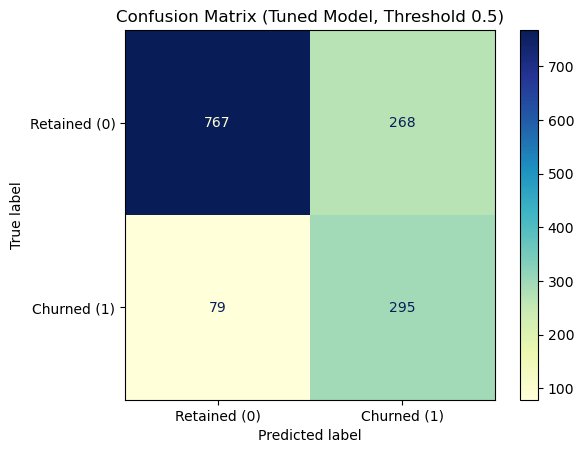

Confusion Matrix(Threshold 0.5):
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.81      0.75      0.77      1409



<Figure size 800x600 with 0 Axes>

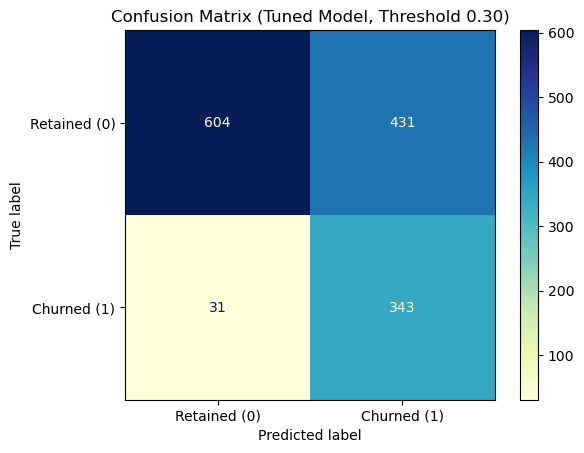

Confusion Matrix(Threshold: 0.3):
              precision    recall  f1-score   support

           0       0.95      0.58      0.72      1035
           1       0.44      0.92      0.60       374

    accuracy                           0.67      1409
   macro avg       0.70      0.75      0.66      1409
weighted avg       0.82      0.67      0.69      1409



In [44]:
y_pred_r=best_pipeline_rec.predict(X_test)
y_proba=best_pipeline_rec.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained (0)', 'Churned (1)'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='YlGnBu')
plt.title('Confusion Matrix (Tuned Model, Threshold 0.5)')
plt.show()
print(f"Confusion Matrix(Threshold 0.5):")
print(classification_report(y_test, y_pred_r))

custom_threshold=0.30
y_pred_custom=(y_proba >=custom_threshold).astype(int)
cm_custom = confusion_matrix(y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=['Retained (0)', 'Churned (1)'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='YlGnBu')
plt.title('Confusion Matrix (Tuned Model, Threshold 0.30)')
plt.show()

print(f"Confusion Matrix(Threshold: {custom_threshold}):")
print(classification_report(y_test, y_pred_custom))

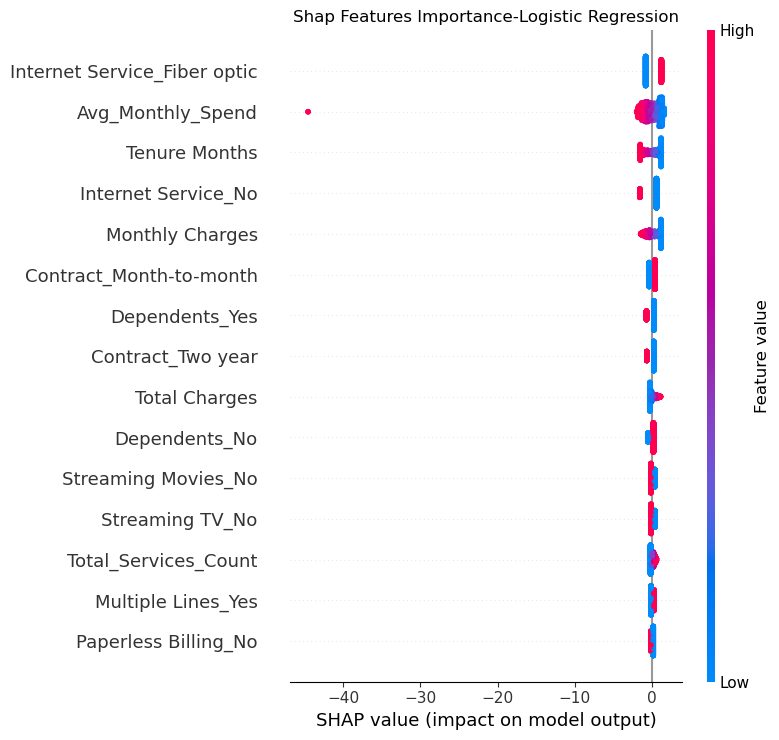


SHAP Summary Plot (Bar):


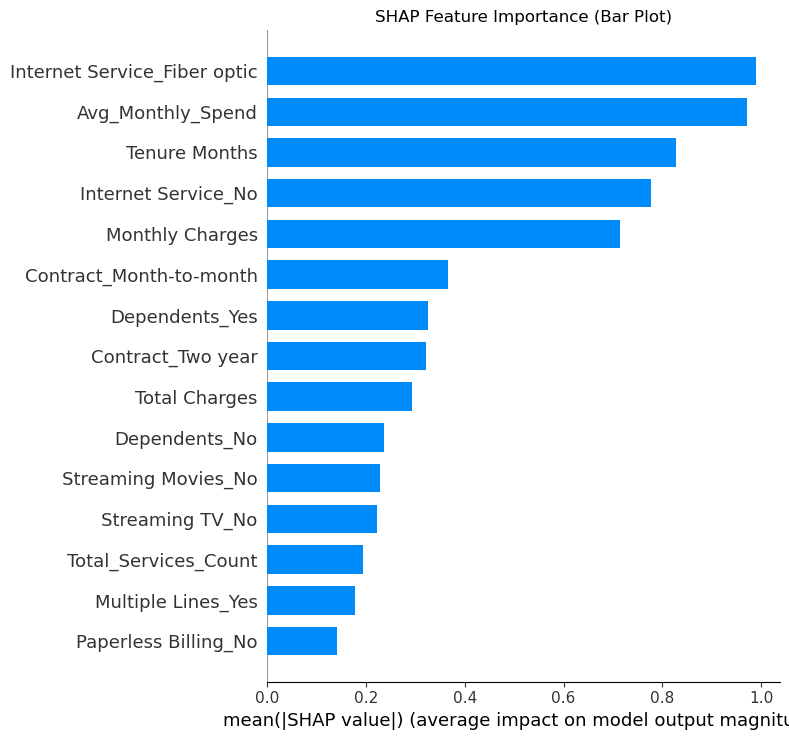

In [96]:
feature_names = best_pipeline_rec.named_steps['preprocess'].get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names]

trained_model=best_pipeline_rec.named_steps['classifier']
X_test_processed=best_pipeline_rec.named_steps['preprocess'].transform(X_test)
X_test_processed_df=pd.DataFrame(
    X_test_processed,
    columns=feature_names
)
 
explainer=shap.LinearExplainer(trained_model,X_test_processed_df)
shap_values=explainer.shap_values(X_test_processed_df)

plt.figure(figsize=(14,10))
shap.summary_plot(shap_values,
                  X_test_processed_df,
                  max_display=15,
                  show=False
                 )
plt.title("Shap Features Importance-Logistic Regression")
plt.tight_layout()
plt.show()

print("\nSHAP Summary Plot (Bar):")

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_test_processed_df,
    plot_type="bar",
    max_display=15,
    show=False
)

plt.title("SHAP Feature Importance (Bar Plot)")
plt.tight_layout()
plt.show()


In [95]:
shap_array=np.array(shap_values)
mean_abs_shap=np.abs(shap_array).mean(axis=0)
shap_importance=pd.DataFrame({
    "Feature":feature_names,
    "Mean_Shap_Values":mean_abs_shap.round(3)
})
shap_importance=shap_importance.sort_values(by="Mean_Shap_Values",ascending=False,ignore_index=True)
print("Top 10 Important Features:")
print(shap_importance.head(10))

Top 10 Important Features:
                        Feature  Mean_Shap_Values
0  Internet Service_Fiber optic             0.989
1             Avg_Monthly_Spend             0.972
2                 Tenure Months             0.827
3           Internet Service_No             0.777
4               Monthly Charges             0.715
5       Contract_Month-to-month             0.367
6                Dependents_Yes             0.325
7             Contract_Two year             0.321
8                 Total Charges             0.292
9                 Dependents_No             0.236
